In [29]:
import os
import numpy as np
import random
from PIL import Image,ImageEnhance

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout 
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle 



In [30]:
train_dir = r'C:\Users\PRANAV JADHAV\OneDrive\Desktop\Brain\Data\Train'
test_dir = r'C:\Users\PRANAV JADHAV\OneDrive\Desktop\Brain\Data\Test'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir , label)):
        train_paths.append(os.path.join(train_dir , label , image))
        train_labels.append(label)


train_paths , train_labels = shuffle(train_paths , train_labels)
# train_paths

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir , label)):
        test_paths.append(os.path.join(test_dir , label , image))
        test_labels.append(label)


test_paths , test_labels = shuffle(test_paths , test_labels)
# test_paths




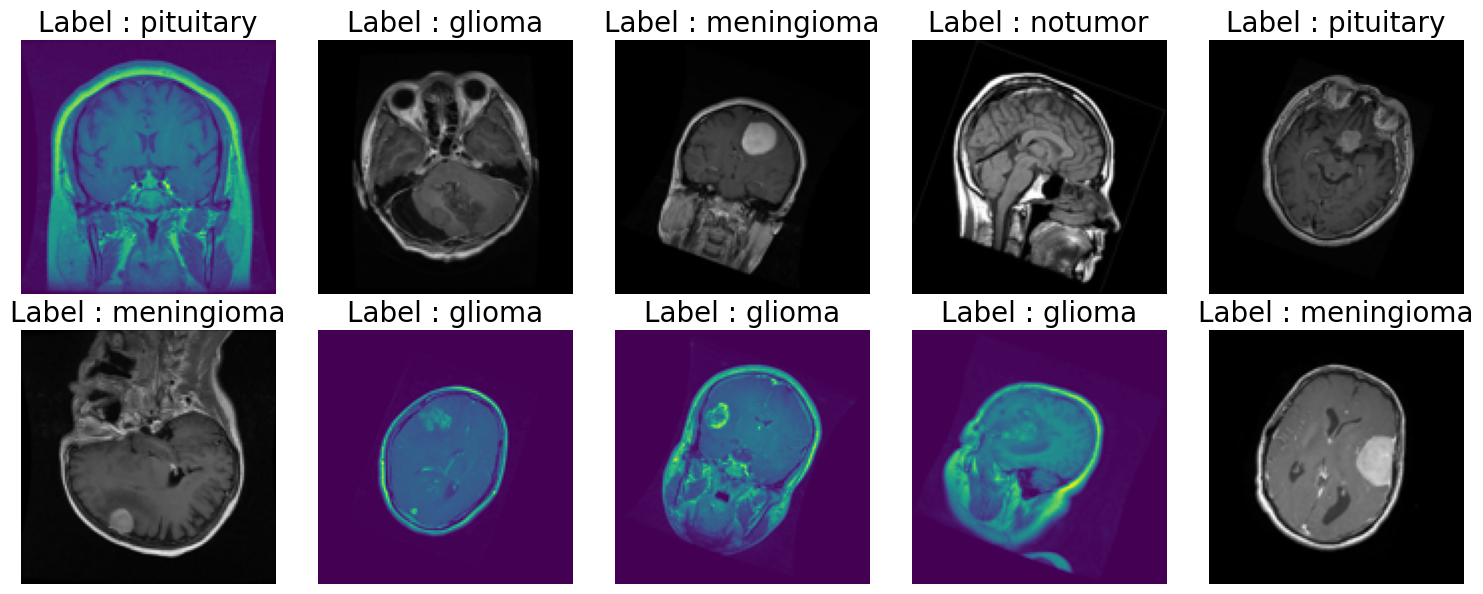

In [31]:
import random
import matplotlib.pyplot as plt

random_indices = random.sample(range(len(train_paths)) , 10)
random_indices

fig , axes = plt.subplots(2,5,figsize = (15,6))
axes = axes.ravel()

for i , idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((128,128))

    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label : {train_labels[idx]}" , fontsize = 20)


plt.tight_layout()
plt.show()



Image Augmentation


In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8 , 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8 , 1.2))
    image = np.array(image)/255.0
    return image

# Load Images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        img = load_img(path , target_size = (128,128))
        img = augment_image(img)
        images.append(img)
    return np.array(images)

# Encoder Labels  (Convert label names into integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)
    encoded = [unique_labels .index(label) for label in unique_labels]
    return encoded

# Data generator for batching
def datagen(paths , labels,batch_size = 12 , epochs = 1):
    for _ in range(epochs):
        for i in range(0 , len(paths) , batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images , batch_labels



In [33]:
# Model Architecture
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

base_model.layers[-2].trainable = True 
base_model.layers[-3].trainable = True 
base_model.layers[-4].trainable = True 

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model) 
model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 5

# Train the model
history = model.fit(
    datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs), 
    steps_per_epoch=steps 
)


ValueError: in user code:

    File "c:\Users\PRANAV JADHAV\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\PRANAV JADHAV\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\PRANAV JADHAV\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\PRANAV JADHAV\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\PRANAV JADHAV\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\PRANAV JADHAV\anaconda3\envs\tf_env\lib\site-packages\keras\engine\compile_utils.py", line 279, in __call__
        batch_dim = tf.shape(y_t)[0]

    ValueError: slice index 0 of dimension 0 out of bounds. for '{{node strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_INT32, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1](Shape, strided_slice/stack, strided_slice/stack_1, strided_slice/stack_2)' with input shapes: [0], [1], [1], [1] and with computed input tensors: input[1] = <0>, input[2] = <1>, input[3] = <1>.
